Name: Farhan Shoukat<br>
Roll No: Fa20/BSAI/048<br>
Lab: 9<br>
Group Memeber : Solo<br>

In [374]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from matplotlib.ticker import MaxNLocator
from copy import copy, deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

#Data Cleaning

In [375]:
url = '/content/drive/MyDrive/ColabData/nba_logreg.csv'
dataset = pd.read_csv(url)
dataset.drop(columns='Name', inplace=True )
dataset.insert(loc = 0, column = 'X0', value = 1) #for theta0 during matrix multiplication
dataset.dropna(inplace=True)
dataset

,X0,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,1,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,1,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,1,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,1,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,1,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,1,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,...,1.5,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8,0.0
1336,1,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,...,1.0,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3,1.0
1337,1,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,...,1.6,64.3,1.5,2.3,3.8,0.3,0.3,0.4,0.9,0.0
1338,1,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,...,1.8,62.5,0.2,0.4,0.7,2.2,0.4,0.1,0.8,1.0


In [376]:
def MeanNormalization(a):
  return ((a-np.mean(a))/np.std(a))

In [377]:
#Nomalization of Features Using Mean Normalization
features = dataset.columns[1:-1]
for i in features:
  dataset[i] = MeanNormalization(dataset[i])

df = dataset.to_numpy()
df.dtype

dtype('float64')

In [378]:
#Seperating Features and Output Columns
x = df[:,:-1]
y = df[:,-1]
No_ofFeatures = 20
print(f"Shape of X : {x.shape}")
print(f"Shape of Y : {y.shape}")

Shape of X : (1329, 20)
Shape of Y : (1329,)


In [379]:
#Creating Train Test Split
train_X,test_X, train_Y, test_Y = train_test_split(x, y, test_size=0.2, random_state= 25)
print(f"Shape of TrainX : {train_X.shape}")
print(f"Shape of TrainY : {train_Y.shape}")
print(f"Shape of TestX : {test_X.shape}")
print(f"Shape of TestY : {test_Y.shape}")

Shape of TrainX : (1063, 20)
Shape of TrainY : (1063,)
Shape of TestX : (266, 20)
Shape of TestY : (266,)


#Logistic Regression Class Implentation

In [380]:
from os import error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random


class Logistic_Regressor:
  def __init__(self, noOfFeature, lr=0.1, regularizer= 'l2', lamda_assign='auto-assign'):
    self.weights = self.InitializeWeights(noOfFeature)
    self.learning_rate = lr
    self. lamda_assign = lamda_assign
    self.lamda = None
    self.regularizer = regularizer
    self.noOfFeature = noOfFeature
    self.ErrorTrain = list()
    self.ErrorValidation = list()


  #////////////////////////////////////////////////////////////////////////////
  #/////THESE ARE FEW GENERIC FUCTIONS THAT ALL THREE(BATCH, STOCHASTIC, MINI-BATCH) GRADIENT DESCENT WILL NEDD
  #///////////////////////////////////////////////////////////////////////////
  
  def resetInitialVariables(self):
    self.weights = self.InitializeWeights(self.noOfFeature)
    self.ErrorTrain = list()
    self.ErrorValidation = list()
    return self

  def IntializeLamda(self, trainX, trainY, kfold_value=5):

    if self.lamda_assign == 'auto-assign':
      print('\n***********************************************\n\tPLEASE WAIT......Preforming KFold to tune Lamba for Regualarization.....')
      dataset = np.c_[trainX, trainY]
      InstancesIn_Fold = len(dataset)//kfold_value

      Fold1 = dataset[:InstancesIn_Fold, :]
      Fold2 = dataset[InstancesIn_Fold : InstancesIn_Fold*2 , :]
      Fold3 = dataset[InstancesIn_Fold*2 : InstancesIn_Fold*3 , :]
      Fold4 = dataset[InstancesIn_Fold*3 : InstancesIn_Fold*4 , :]
      Fold5 = dataset[InstancesIn_Fold*4 : InstancesIn_Fold*5, :]

      Fold_List = [Fold1, Fold2, Fold3, Fold4, Fold5]
      holdout_score = list()
      lamda_holdout = dict()
      lamda_weights = deepcopy(self.weights)
      for i in np.arange(0.001, 1, 0.005):
        self.lamda = i
        temp_holdoutScore = list()
        for c in range(kfold_value):
          self.weights = deepcopy(lamda_weights)
          TrainingData =  np.vstack(tuple([x for x in Fold_List if True in (np.where(x != Fold_List[c], True, False))]))
          TestingData = Fold_List[c]
          trX, trY, teX, teY = TrainingData[:,:-1], TrainingData[:,-1], TestingData[:,:-1], TestingData[:,-1]
          self.Batch_GD(trX, trY, teX, teY, kfoldInProgess=True)
          temp_holdoutScore.append(self.ErrorValidation[-1])
          self.resetInitialVariables()
        lamda_holdout[i] = np.mean(temp_holdoutScore)
      self.resetInitialVariables()
      self.lamda = min(lamda_holdout, key=lamda_holdout.get)
    else:
      self.lamda = random.uniform(0.001, 1)

    return self

  def InitializeWeights(self, noofFeatures):
    temp = list()
    for i in range(noofFeatures):
      temp.append(random.uniform(0.001, 0.1))
    return np.array(temp)

  def Pridction(self, x, getLabel = False):
      if getLabel == True:
        sig = 1/(1 + np.exp(- np.matmul(x, self.weights)))
        sig = np.minimum(sig, 0.9999)
        sig = np.maximum(sig, 0.0001)
        return self.Generic_GetLabels(sig)
      else:
        sig = 1/(1 + np.exp(- np.matmul(x, self.weights)))
        sig = np.minimum(sig, 0.9999)
        return np.maximum(sig, 0.0001)
        
  def Generic_BinaryCrossEntropy(self, pridicted, actual):
      noOfInstance = actual.shape[0]
      tempTheta = deepcopy(self.weights)
      tempTheta[0] = 0
      if self.regularizer == 'l2':
        return (np.sum(-((actual * np.log2(pridicted)) + ((1 - actual) * np.log2(1-pridicted))))/noOfInstance) + \
                     (self.lamda/(2*noOfInstance))*np.matmul(tempTheta.transpose(), tempTheta)
      elif self.regularizer == 'l1':
        return (np.sum(-((actual * np.log2(pridicted)) + ((1 - actual) * np.log2(1-pridicted))))/noOfInstance) + \
                     (self.lamda/noOfInstance)*np.absolute(tempTheta).sum()
      else:
        return np.sum(-((actual * np.log2(pridicted)) + ((1 - actual) * np.log2(1-pridicted))))/noOfInstance
  
  def Generic_DerivateWeights(self, pridcted, actual, actualX):
      noOfInstance = actualX.shape[0]
      tempTheta = deepcopy(self.weights)
      tempTheta[0] = 0
      if self.regularizer == 'l2':
        return (np.matmul(actualX.transpose(), (pridcted-actual))/noOfInstance) + (self.lamda/noOfInstance)*tempTheta
      elif self.regularizer == 'l1':
        return (np.matmul(actualX.transpose(), (pridcted-actual))/noOfInstance) + (self.lamda/noOfInstance)*np.sign(tempTheta)
      else:
        return (np.matmul(actualX.transpose(), (pridcted-actual))/noOfInstance)

  def Generic_UpdateWeights(self, derivate):
      new_weights = list()
      for i in range(len(derivate)):
        new_weights.append((self.weights[i]-derivate[i]*self.learning_rate))
      self.weights = np.array(new_weights)

  def Generic_AccuracyScore(self, actual, pridicted):
    return np.round(accuracy_score(actual, pridicted), 4)

  def Generic_GetLabels(self, pridicted):
    return np.where(pridicted>0.5, 1, 0)

  def earlyStopping(self, val, best, b_weights, count , pait, monitor, c, kfoldInProgess):
    if c > 0:
      if monitor == 'val_error':
        if val < best:
          b_weights = deepcopy(self.weights)
          best = val
          count = 0
        else:
          count+=1
      else:
        if val > best:
          b_weights = deepcopy(self.weights)
          best = val
          count = 0
        else:
          count+=1

      if self.ErrorValidation[c-1] < self.ErrorValidation[c] or count > 15:
        pait+=1
        if pait > 3:
          self.weights = deepcopy(b_weights)
          if kfoldInProgess == False:
            print('****************BEST WEIGHTS ON WHICH HIGHEST ACCURACY ACHIEVED - RESTORIED******************')
          return True, best, b_weights, count, pait
        else:
          return False, best, b_weights, count, pait
      else:
        pait = 0
        return False, best, b_weights, count, pait
    else:
      return False, best, self.weights, count, pait



  
  #////////////////////////////////////////////////////////////////////////////
  #/////THESE ARE IMPLEMENTAION OF THE THREE(BATCH, STOCHASTIC, MINI-BATCH) GRADIENT DESCENT
  #///////////////////////////////////////////////////////////////////////////

  #*******BATCH GRADIENT DESCENT********

  def Batch_GD(self, trainX, trainY, testX, testY, monitor='val_error', kfoldInProgess=False):
      if kfoldInProgess == False:
        if monitor == 'val_error':
          best_error = 0
        else:
          best_accuracy = 0

        Patience = 0
        No_ofIteration = 0
        best_weights = deepcopy(self.weights)
        bestUnchangedCount = 0

        for c in range(100000000):
          print(f"Epoch {c+1}:\n")
          hTrain = self.Pridction(trainX)
          JTrain = self.Generic_BinaryCrossEntropy(hTrain, trainY)
          derivate_weights = self.Generic_DerivateWeights(hTrain, trainY, trainX)
          self.Generic_UpdateWeights(derivate_weights)

          self.ErrorTrain.append(JTrain)
          validation = self.Pridction(testX)
          validationError = np.round(self.Generic_BinaryCrossEntropy(validation, testY),8)
          validation = self.Generic_GetLabels(validation)
          validation_acc = self.Generic_AccuracyScore(testY, validation)
          self.ErrorValidation.append(validationError)


          print("Traning Error : ", end = " ")
          print(f"{np.round(self.ErrorTrain[c],8)}   ||   Validation Error : {validationError}    Validation Accuracy : {validation_acc}  ")
          print()
          print("===========================================================================================================================================")
          if monitor == 'val_error':
            loopBreaker, best_error, best_weights, bestUnchangedCount, Patience = self.earlyStopping(validationError, best_error, best_weights, bestUnchangedCount, Patience, monitor, c, kfoldInProgess)
            if(loopBreaker == True):
              break
          else:
            loopBreaker, best_accuracy, best_weights, bestUnchangedCount, Patience = self.earlyStopping(validation_acc, best_accuracy, best_weights, bestUnchangedCount, Patience, monitor, c, kfoldInProgess)
            if(loopBreaker == True):
              break
      else:
        if monitor == 'val_error':
          best_error = 0
        else:
          best_accuracy = 0

        Patience = 0
        No_ofIteration = 0
        best_weights = deepcopy(self.weights)
        bestUnchangedCount = 0

        for c in range(100000000):
          hTrain = self.Pridction(trainX)
          JTrain = self.Generic_BinaryCrossEntropy(hTrain, trainY)
          derivate_weights = self.Generic_DerivateWeights(hTrain, trainY, trainX)
          self.Generic_UpdateWeights(derivate_weights)

          self.ErrorTrain.append(JTrain)
          validation = self.Pridction(testX)
          validationError = np.round(self.Generic_BinaryCrossEntropy(validation, testY),8)
          validation = self.Generic_GetLabels(validation)
          validation_acc = self.Generic_AccuracyScore(testY, validation)
          self.ErrorValidation.append(validationError)

          if monitor == 'val_error':
            loopBreaker, best_error, best_weights, bestUnchangedCount, Patience = self.earlyStopping(validationError, best_error, best_weights, bestUnchangedCount, Patience, monitor, c, kfoldInProgess)
            if(loopBreaker == True):
              break
          else:
            loopBreaker, best_accuracy, best_weights, bestUnchangedCount, Patience = self.earlyStopping(validation_acc, best_accuracy, best_weights, bestUnchangedCount, monitor, Patience, c, kfoldInProgess)
            if(loopBreaker == True):
              break

      return self  
  

  #*******STOCHASTIC GRADIENT DESCENT********

  def Stochastic_GD(self, trainX, trainY, testX, testY, monitor='val-error', kfoldInProgess=False):

    def Stochastic_BinaryCrossEntropy(pridicted, actual):
      tempTheta = deepcopy(self.weights)
      tempTheta[0] = 0
      if self.regularizer == 'l2':
        return (-((actual * np.log2(pridicted)) + ((1 - actual) * np.log2(1-pridicted)))) + \
                        (self.lamda/2)*np.matmul(tempTheta.transpose(), tempTheta)
      elif self.regularizer == 'l1':
        return (-((actual * np.log2(pridicted)) + ((1 - actual) * np.log2(1-pridicted)))) + \
                        (self.lamda)*np.absolute(tempTheta).sum()
      else:
        return -((actual * np.log2(pridicted)) + ((1 - actual) * np.log2(1-pridicted)))

    def Stochastic_DerivateWeights(pridicted, actual, actualX):
      tempTheta = deepcopy(self.weights)
      tempTheta[0] = 0
      if self.regularizer == 'l2':
        return actualX * (pridicted-actual) + (self.lamda)*tempTheta
      elif self.regularizer == 'l1':
        return actualX * (pridicted-actual) + (self.lamda)*np.sign(tempTheta)
      else:
        return actualX * (pridicted-actual)

    if monitor == 'val_error':
        best_error = 0
    else:
        best_accuracy = 0

    Patience = 0
    No_ofIteration = 0
    best_weights = deepcopy(self.weights)
    bestUnchangedCount = 0

    for c in range(100000000):
      print(f"Epoch {c+1}:\n")

      tempTrainError = list()
      for r in range(len(trainX)):
        hTrain = self.Pridction(trainX[r,:])
        JTrain = Stochastic_BinaryCrossEntropy(hTrain, trainY[r])
        tempTrainError.append(JTrain)
        derivate_weights = Stochastic_DerivateWeights(hTrain, trainY[r], trainX[r,:])
        self.Generic_UpdateWeights(derivate_weights)
    
      self.ErrorTrain.append(np.mean(tempTrainError))
      validation = self.Pridction(testX)
      validationError = np.round(self.Generic_BinaryCrossEntropy(validation, testY),8)
      validation = self.Generic_GetLabels(validation)
      validation_acc = self.Generic_AccuracyScore(test_Y, validation)
      self.ErrorValidation.append(validationError)

      print(end=f"{r}/{len(trainX)-1} :   Traning Error : ")
      print(f"{np.round(self.ErrorTrain[c],8)}   ||   Validation Error : {validationError}    Validation Accuracy : {validation_acc}  ")
      print()
      print("===========================================================================================================================================")
      
      if monitor == 'val_error':
          loopBreaker, best_error, best_weights, bestUnchangedCount, Patience = self.earlyStopping(validationError, best_error, best_weights, bestUnchangedCount, Patience, monitor, c,kfoldInProgess)
          if(loopBreaker == True):
            break
      else:
          loopBreaker, best_accuracy, best_weights, bestUnchangedCount, Patience = self.earlyStopping(validation_acc, best_accuracy, best_weights, bestUnchangedCount, Patience, monitor, c, kfoldInProgess)
          if(loopBreaker == True):
            break
    
    return self



  #*******MINI-BATCH GRADIENT DESCENT********

  def MiniBatch_GD(self, trainX, trainY, testX, testY, batch_size, monitor='val-error', kfoldInProgess= False):
    
    if monitor == 'val_error':
        best_error = 0
    else:
        best_accuracy = 0

    Patience = 0
    No_ofIteration = 0
    best_weights = deepcopy(self.weights)
    bestUnchangedCount = 0
    No_ofDataPerEpoch = len(trainX)//batch_size

    for c in range(100000000):
      print(f"Epoch {c+1}:\n")

      batch_start = 0
      batch_end = 0
      tempTrainError = list()

      for r in range(No_ofDataPerEpoch):
        batch_start = batch_end
        batch_end = batch_start + batch_size
        hTrain = self.Pridction(trainX[batch_start:batch_end,:])
        JTrain = self.Generic_BinaryCrossEntropy(hTrain, trainY[batch_start:batch_end])
        tempTrainError.append(JTrain)
        derivate_weights = self.Generic_DerivateWeights(hTrain, trainY[batch_start:batch_end], trainX[batch_start:batch_end,:])
        self.Generic_UpdateWeights(derivate_weights)

      self.ErrorTrain.append(np.mean(tempTrainError))
      validation = self.Pridction(testX)
      validationError = np.round(self.Generic_BinaryCrossEntropy(validation, testY),8)
      validation = self.Generic_GetLabels(validation)
      validation_acc = self.Generic_AccuracyScore(test_Y, validation)
      self.ErrorValidation.append(validationError)

      print(end="Traning Error : ")
      print(f"{np.round(self.ErrorTrain[c],8)}   ||   Validation Error : {validationError}    Validation Accuracy : {validation_acc}  ")
      print()
      print("===========================================================================================================================================")
      
      if monitor == 'val_error':
          loopBreaker, best_error, best_weights, bestUnchangedCount, Patience = self.earlyStopping(validationError, best_error, best_weights, bestUnchangedCount, Patience, monitor, c, kfoldInProgess)
          if(loopBreaker == True):
            break
      else:
          loopBreaker, best_accuracy, best_weights, bestUnchangedCount, Patience = self.earlyStopping(validation_acc, best_accuracy, best_weights, bestUnchangedCount,Patience, monitor, c, kfoldInProgess)
          if(loopBreaker == True):
            break
    
    return self


#Batch Gradient Descent 

-----------------***********---------------------<br>
Batch Gradient Descent with L2 Regualarization<br>
-----------------***********---------------------<br>

In [381]:
Batch_ModelL2 = Logistic_Regressor(No_ofFeatures, 0.1, regularizer='l2')
Batch_ModelL2.IntializeLamda(train_X, train_Y)
Batch_ModelL2.Batch_GD(train_X, train_Y, test_X, test_Y, monitor='val_accuracy')


***********************************************
	PLEASE WAIT......Preforming KFold to tune Lamba for Regualarization.....
Epoch 1:

Traning Error :  0.8965389   ||   Validation Error : 0.91635312    Validation Accuracy : 0.6767  

Epoch 2:

Traning Error :  0.8897637   ||   Validation Error : 0.91141887    Validation Accuracy : 0.6805  

Epoch 3:

Traning Error :  0.88435127   ||   Validation Error : 0.90713787    Validation Accuracy : 0.6842  

Epoch 4:

Traning Error :  0.87985924   ||   Validation Error : 0.90331174    Validation Accuracy : 0.688  

Epoch 5:

Traning Error :  0.87601213   ||   Validation Error : 0.89981657    Validation Accuracy : 0.688  

Epoch 6:

Traning Error :  0.87263307   ||   Validation Error : 0.89657305    Validation Accuracy : 0.688  

Epoch 7:

Traning Error :  0.86960528   ||   Validation Error : 0.89352923    Validation Accuracy : 0.6917  

Epoch 8:

Traning Error :  0.86684975   ||   Validation Error : 0.89065026    Validation Accuracy : 0.688  

Epo

In [382]:
validation_prediction_BatchL2 = Batch_ModelL2.Pridction(test_X, getLabel=True)
print(f"Accuracy on Validation Data : {Batch_ModelL2.Generic_AccuracyScore(test_Y, validation_prediction_BatchL2)}")

Accuracy on Validation Data : 0.7068


<function matplotlib.pyplot.show>

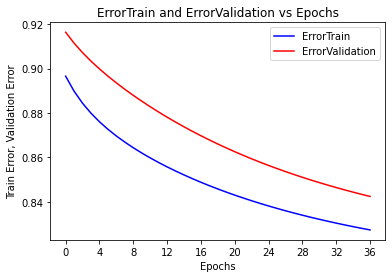

In [383]:
plt.plot(range(len(Batch_ModelL2.ErrorTrain)), Batch_ModelL2.ErrorTrain, c= 'blue', label = 'ErrorTrain')
plt.plot(range(len(Batch_ModelL2.ErrorValidation)), Batch_ModelL2.ErrorValidation, c= 'red', label = 'ErrorValidation')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('Train Error, Validation Error')
plt.title("ErrorTrain and ErrorValidation vs Epochs")
plt.legend()
plt.show

              precision    recall  f1-score   support

         0.0       0.58      0.70      0.64        98
         1.0       0.80      0.71      0.75       168

    accuracy                           0.71       266
   macro avg       0.69      0.71      0.70       266
weighted avg       0.72      0.71      0.71       266

Accuracy :  0.706766917293233


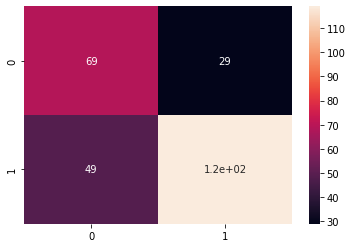

In [384]:
print(classification_report(test_Y, validation_prediction_BatchL2))
conf_Matrix_BGDL2 = confusion_matrix(test_Y, validation_prediction_BatchL2)
sns.heatmap(conf_Matrix_BGDL2, annot=True)
print("Accuracy : ", (conf_Matrix_BGDL2[0,0] + conf_Matrix_BGDL2[1,1])/(np.sum(conf_Matrix_BGDL2)))

-----------------***********---------------------<br>
Batch Gradient Descent with L1 Regualarization<br>
-----------------***********---------------------<br>

In [385]:
Batch_ModelL1 = Logistic_Regressor(No_ofFeatures, 0.1, regularizer='l1')
Batch_ModelL1.IntializeLamda(train_X, train_Y)
Batch_ModelL1.Batch_GD(train_X, train_Y, test_X, test_Y, monitor='val_accuracy')


***********************************************
	PLEASE WAIT......Preforming KFold to tune Lamba for Regualarization.....
Epoch 1:

Traning Error :  0.89175387   ||   Validation Error : 0.9106503    Validation Accuracy : 0.6654  

Epoch 2:

Traning Error :  0.88540227   ||   Validation Error : 0.90612979    Validation Accuracy : 0.6692  

Epoch 3:

Traning Error :  0.88029035   ||   Validation Error : 0.90219269    Validation Accuracy : 0.6692  

Epoch 4:

Traning Error :  0.87603046   ||   Validation Error : 0.89866923    Validation Accuracy : 0.6692  

Epoch 5:

Traning Error :  0.87237717   ||   Validation Error : 0.8954516    Validation Accuracy : 0.6767  

Epoch 6:

Traning Error :  0.86917027   ||   Validation Error : 0.89246961    Validation Accuracy : 0.6767  

Epoch 7:

Traning Error :  0.86630227   ||   Validation Error : 0.88967641    Validation Accuracy : 0.6805  

Epoch 8:

Traning Error :  0.86369921   ||   Validation Error : 0.88704    Validation Accuracy : 0.6805  

Ep

In [386]:
validation_prediction_BatchL1 = Batch_ModelL1.Pridction(test_X, getLabel=True)
print(f"Accuracy on Validation Data : {Batch_ModelL1.Generic_AccuracyScore(test_Y, validation_prediction_BatchL1)}")

Accuracy on Validation Data : 0.6992


<function matplotlib.pyplot.show>

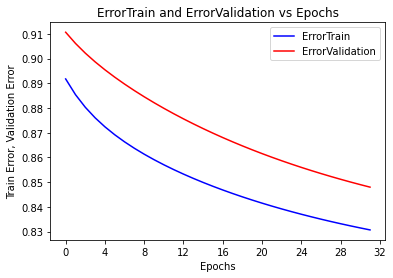

In [388]:
plt.plot(range(len(Batch_ModelL1.ErrorTrain)), Batch_ModelL1.ErrorTrain, c= 'blue', label = 'ErrorTrain')
plt.plot(range(len(Batch_ModelL1.ErrorValidation)), Batch_ModelL1.ErrorValidation, c= 'red', label = 'ErrorValidation')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('Train Error, Validation Error')
plt.title("ErrorTrain and ErrorValidation vs Epochs")
plt.legend()
plt.show

              precision    recall  f1-score   support

         0.0       0.57      0.71      0.64        98
         1.0       0.81      0.69      0.74       168

    accuracy                           0.70       266
   macro avg       0.69      0.70      0.69       266
weighted avg       0.72      0.70      0.70       266

Accuracy :  0.6992481203007519


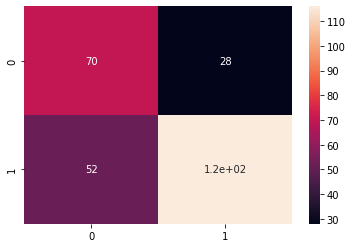

In [389]:
print(classification_report(test_Y, validation_prediction_BatchL1))
conf_Matrix_BGDL1 = confusion_matrix(test_Y, validation_prediction_BatchL1)
sns.heatmap(conf_Matrix_BGDL1, annot=True)
print("Accuracy : ", (conf_Matrix_BGDL1[0,0] + conf_Matrix_BGDL1[1,1])/(np.sum(conf_Matrix_BGDL1)))

-----------------***********---------------------<br>
Comparing L1 and L2 on Batch Gradient Descent<br>
-----------------***********---------------------<br>

<function matplotlib.pyplot.show>

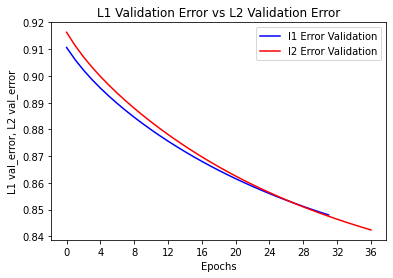

In [407]:
plt.plot(range(len(Batch_ModelL1.ErrorValidation)), Batch_ModelL1.ErrorValidation, c= 'blue', label = 'l1 Error Validation')
plt.plot(range(len(Batch_ModelL2.ErrorValidation)), Batch_ModelL2.ErrorValidation, c= 'red', label = 'l2 Error Validation')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('L1 val_error, L2 val_error')
plt.title("L1 Validation Error vs L2 Validation Error")
plt.legend()
plt.show

From the graph it can be seen that Validation Error on l1 is smaller at beginning but slowly start to get equal to l2 regularization. So overall for this dataset there isn't a very big difference in the preformance of l1 and l2 regualarization.

#Stochastic Gradient Descent

-----------------***********---------------------<br>
Stochastic Gradient Descent with L2 Regualarization<br>
-----------------***********---------------------<br>

In [390]:
SGD_ModelL2 = Logistic_Regressor(No_ofFeatures, 0.1, regularizer='l2')
SGD_ModelL2.IntializeLamda(train_X, train_Y)
SGD_ModelL2.Stochastic_GD(train_X, train_Y, test_X, test_Y, monitor='val_accuracy')


***********************************************
	PLEASE WAIT......Preforming KFold to tune Lamba for Regualarization.....
Epoch 1:

1062/1062 :   Traning Error : 0.94319628   ||   Validation Error : 0.83873204    Validation Accuracy : 0.7218  

Epoch 2:

1062/1062 :   Traning Error : 0.93580059   ||   Validation Error : 0.84180498    Validation Accuracy : 0.7218  

Epoch 3:

1062/1062 :   Traning Error : 0.93507043   ||   Validation Error : 0.8437951    Validation Accuracy : 0.7218  

Epoch 4:

1062/1062 :   Traning Error : 0.93491001   ||   Validation Error : 0.84476517    Validation Accuracy : 0.7218  

Epoch 5:

1062/1062 :   Traning Error : 0.9348059   ||   Validation Error : 0.84520851    Validation Accuracy : 0.7256  

****************BEST WEIGHTS ON WHICH HIGHEST ACCURACY ACHIEVED - RESTORIED******************


In [391]:
validation_predictionL2 = SGD_ModelL2.Pridction(test_X, getLabel=True)
print(f"Accuracy on Testing Data : {SGD_ModelL2.Generic_AccuracyScore(test_Y, validation_predictionL2)}")

Accuracy on Testing Data : 0.7256


<function matplotlib.pyplot.show>

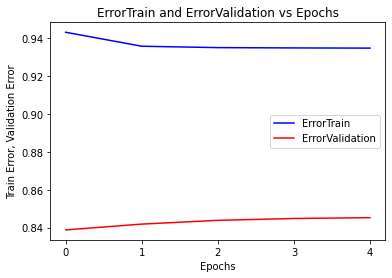

In [392]:
plt.plot(range(len(SGD_ModelL2.ErrorTrain)), SGD_ModelL2.ErrorTrain, c= 'blue', label = 'ErrorTrain')
plt.plot(range(len(SGD_ModelL2.ErrorValidation)), SGD_ModelL2.ErrorValidation, c= 'red', label = 'ErrorValidation')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('Train Error, Validation Error')
plt.title("ErrorTrain and ErrorValidation vs Epochs")
plt.legend()
plt.show

              precision    recall  f1-score   support

         0.0       0.63      0.62      0.63        98
         1.0       0.78      0.79      0.78       168

    accuracy                           0.73       266
   macro avg       0.70      0.70      0.70       266
weighted avg       0.72      0.73      0.73       266

Accuracy :  0.7255639097744361


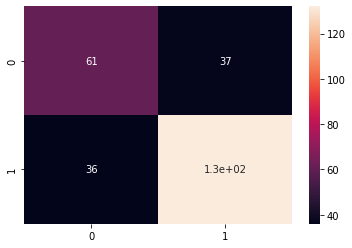

In [393]:
print(classification_report(test_Y, validation_predictionL2))
conf_Matrix_SGDL2 = confusion_matrix(test_Y, validation_predictionL2)
sns.heatmap(conf_Matrix_SGDL2, annot=True)
print("Accuracy : ", (conf_Matrix_SGDL2[0,0] + conf_Matrix_SGDL2[1,1])/(np.sum(conf_Matrix_SGDL2)))

-----------------***********---------------------<br>
Stochastic Gradient Descent with L1 Regualarization<br>
-----------------***********---------------------<br>

In [394]:
SGD_ModelL1 = Logistic_Regressor(No_ofFeatures, 0.1, regularizer='l1')
SGD_ModelL1.IntializeLamda(train_X, train_Y)
SGD_ModelL1.Stochastic_GD(train_X, train_Y, test_X, test_Y, monitor='val_accuracy')


***********************************************
	PLEASE WAIT......Preforming KFold to tune Lamba for Regualarization.....
Epoch 1:

1062/1062 :   Traning Error : 0.94584798   ||   Validation Error : 0.83872197    Validation Accuracy : 0.7218  

Epoch 2:

1062/1062 :   Traning Error : 0.93956696   ||   Validation Error : 0.84178288    Validation Accuracy : 0.718  

Epoch 3:

1062/1062 :   Traning Error : 0.93890561   ||   Validation Error : 0.84402935    Validation Accuracy : 0.7218  

Epoch 4:

1062/1062 :   Traning Error : 0.9387481   ||   Validation Error : 0.84526334    Validation Accuracy : 0.718  

Epoch 5:

1062/1062 :   Traning Error : 0.93863609   ||   Validation Error : 0.84594939    Validation Accuracy : 0.7218  

****************BEST WEIGHTS ON WHICH HIGHEST ACCURACY ACHIEVED - RESTORIED******************


In [395]:
validation_predictionL1 = SGD_ModelL1.Pridction(test_X, getLabel=True)
print(f"Accuracy on Testing Data : {SGD_ModelL1.Generic_AccuracyScore(test_Y, validation_predictionL1)}")

Accuracy on Testing Data : 0.7218


<function matplotlib.pyplot.show>

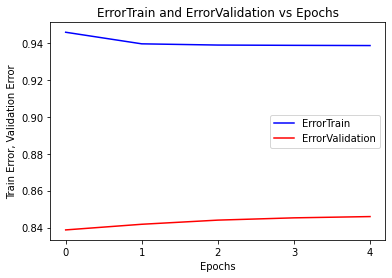

In [396]:
plt.plot(range(len(SGD_ModelL1.ErrorTrain)), SGD_ModelL1.ErrorTrain, c= 'blue', label = 'ErrorTrain')
plt.plot(range(len(SGD_ModelL1.ErrorValidation)), SGD_ModelL1.ErrorValidation, c= 'red', label = 'ErrorValidation')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('Train Error, Validation Error')
plt.title("ErrorTrain and ErrorValidation vs Epochs")
plt.legend()
plt.show

              precision    recall  f1-score   support

         0.0       0.62      0.63      0.63        98
         1.0       0.78      0.77      0.78       168

    accuracy                           0.72       266
   macro avg       0.70      0.70      0.70       266
weighted avg       0.72      0.72      0.72       266

Accuracy :  0.7218045112781954


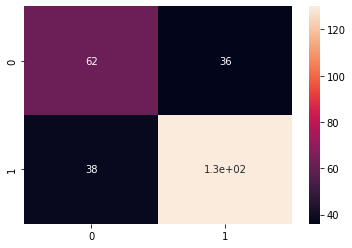

In [397]:
print(classification_report(test_Y, validation_predictionL1))
conf_Matrix_SGDL1 = confusion_matrix(test_Y, validation_predictionL1)
sns.heatmap(conf_Matrix_SGDL1, annot=True)
print("Accuracy : ", (conf_Matrix_SGDL1[0,0] + conf_Matrix_SGDL1[1,1])/(np.sum(conf_Matrix_SGDL1)))

-----------------***********---------------------<br>
Comparing L1 and L2 on Stochastic Gradient Descent<br>
-----------------***********---------------------<br>

<function matplotlib.pyplot.show>

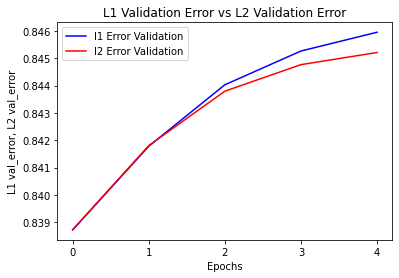

In [408]:
plt.plot(range(len(SGD_ModelL1.ErrorValidation)), SGD_ModelL1.ErrorValidation, c= 'blue', label = 'l1 Error Validation')
plt.plot(range(len(SGD_ModelL2.ErrorValidation)), SGD_ModelL2.ErrorValidation, c= 'red', label = 'l2 Error Validation')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('L1 val_error, L2 val_error')
plt.title("L1 Validation Error vs L2 Validation Error")
plt.legend()
plt.show

In Stochastic our model has already acheived its best accuracy at the start, meaning it converged very quickly. After that the validation error start increasing for both regularization and suddenly the validation error with l1 increased more then l2. Also with l2 we acheieved the highest possible accuracy of 0.7256. Still there isn't very big difference in the perfomance both l1 and l2 regularization.

#Mini-Batch Gradient Descent 

-----------------***********---------------------<br>
Mini Batch Gradient Descent with L2 Regualarization<br>
-----------------***********---------------------<br>

In [398]:
MiniBatch_ModelL2 = Logistic_Regressor(No_ofFeatures, 0.1, regularizer='l2')
MiniBatch_ModelL2.IntializeLamda(train_X, train_Y)
MiniBatch_ModelL2.MiniBatch_GD(train_X, train_Y, test_X, test_Y, 32, monitor='val_accuracy')


***********************************************
	PLEASE WAIT......Preforming KFold to tune Lamba for Regualarization.....
Epoch 1:

Traning Error : 0.85901052   ||   Validation Error : 0.85101361    Validation Accuracy : 0.7068  

Epoch 2:

Traning Error : 0.82816024   ||   Validation Error : 0.83023168    Validation Accuracy : 0.718  

Epoch 3:

Traning Error : 0.81902438   ||   Validation Error : 0.82221898    Validation Accuracy : 0.7068  

Epoch 4:

Traning Error : 0.81553157   ||   Validation Error : 0.81846811    Validation Accuracy : 0.7068  

Epoch 5:

Traning Error : 0.8138834   ||   Validation Error : 0.81638569    Validation Accuracy : 0.7068  

Epoch 6:

Traning Error : 0.81291593   ||   Validation Error : 0.81504476    Validation Accuracy : 0.7143  

Epoch 7:

Traning Error : 0.81223301   ||   Validation Error : 0.81407142    Validation Accuracy : 0.7143  

Epoch 8:

Traning Error : 0.81168714   ||   Validation Error : 0.81330003    Validation Accuracy : 0.7143  

Epoch 9

In [399]:
validation_prediction_MBatchL2 = MiniBatch_ModelL2.Pridction(test_X, getLabel=True)
print(f"Accuracy on Testing Data : {MiniBatch_ModelL2.Generic_AccuracyScore(test_Y, validation_prediction_MBatchL2)}")

Accuracy on Testing Data : 0.7218


<function matplotlib.pyplot.show>

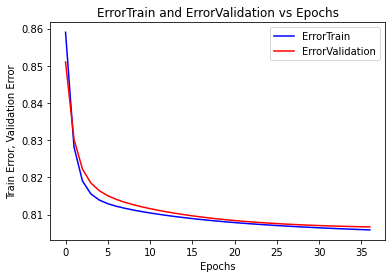

In [400]:
plt.plot(range(len(MiniBatch_ModelL2.ErrorTrain)), MiniBatch_ModelL2.ErrorTrain, c= 'blue', label = 'ErrorTrain')
plt.plot(range(len(MiniBatch_ModelL2.ErrorValidation)), MiniBatch_ModelL2.ErrorValidation, c= 'red', label = 'ErrorValidation')
plt.xlabel('Epochs')
plt.ylabel('Train Error, Validation Error')
plt.title("ErrorTrain and ErrorValidation vs Epochs")
plt.legend()
plt.show

              precision    recall  f1-score   support

         0.0       0.65      0.54      0.59        98
         1.0       0.76      0.83      0.79       168

    accuracy                           0.72       266
   macro avg       0.70      0.68      0.69       266
weighted avg       0.72      0.72      0.72       266

Accuracy :  0.7218045112781954


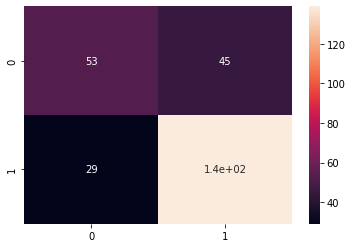

In [401]:
print(classification_report(test_Y, validation_prediction_MBatchL2))
conf_Matrix_MBGDL2 = confusion_matrix(test_Y, validation_prediction_MBatchL2)
sns.heatmap(conf_Matrix_MBGDL2, annot=True)
print("Accuracy : ", (conf_Matrix_MBGDL2[0,0] + conf_Matrix_MBGDL2[1,1])/(np.sum(conf_Matrix_MBGDL2)))

-----------------***********---------------------<br>
Mini Batch Gradient Descent with L1 Regualarization<br>
-----------------***********---------------------<br>

In [402]:
MiniBatch_ModelL1 = Logistic_Regressor(No_ofFeatures, 0.1, regularizer='l1')
MiniBatch_ModelL1.IntializeLamda(train_X, train_Y)
MiniBatch_ModelL1.MiniBatch_GD(train_X, train_Y, test_X, test_Y, 32, monitor='val_accuracy')


***********************************************
	PLEASE WAIT......Preforming KFold to tune Lamba for Regualarization.....
Epoch 1:

Traning Error : 0.86087178   ||   Validation Error : 0.85226284    Validation Accuracy : 0.7143  

Epoch 2:

Traning Error : 0.82842254   ||   Validation Error : 0.82950339    Validation Accuracy : 0.7105  

Epoch 3:

Traning Error : 0.81860039   ||   Validation Error : 0.82109262    Validation Accuracy : 0.7068  

Epoch 4:

Traning Error : 0.81497439   ||   Validation Error : 0.8173687    Validation Accuracy : 0.7068  

Epoch 5:

Traning Error : 0.81333132   ||   Validation Error : 0.81542067    Validation Accuracy : 0.7105  

Epoch 6:

Traning Error : 0.81240206   ||   Validation Error : 0.8142255    Validation Accuracy : 0.7143  

Epoch 7:

Traning Error : 0.81176235   ||   Validation Error : 0.81338238    Validation Accuracy : 0.7143  

Epoch 8:

Traning Error : 0.81125748   ||   Validation Error : 0.81272069    Validation Accuracy : 0.7143  

Epoch 9

In [403]:
validation_prediction_MBatchL1 = MiniBatch_ModelL1.Pridction(test_X, getLabel=True)
print(f"Accuracy on Testing Data : {MiniBatch_ModelL1.Generic_AccuracyScore(test_Y, validation_prediction_MBatchL1)}")

Accuracy on Testing Data : 0.718


<function matplotlib.pyplot.show>

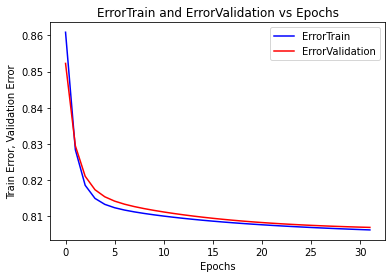

In [404]:
plt.plot(range(len(MiniBatch_ModelL1.ErrorTrain)), MiniBatch_ModelL1.ErrorTrain, c= 'blue', label = 'ErrorTrain')
plt.plot(range(len(MiniBatch_ModelL1.ErrorValidation)), MiniBatch_ModelL1.ErrorValidation, c= 'red', label = 'ErrorValidation')
plt.xlabel('Epochs')
plt.ylabel('Train Error, Validation Error')
plt.title("ErrorTrain and ErrorValidation vs Epochs")
plt.legend()
plt.show

              precision    recall  f1-score   support

         0.0       0.64      0.54      0.59        98
         1.0       0.75      0.82      0.79       168

    accuracy                           0.72       266
   macro avg       0.70      0.68      0.69       266
weighted avg       0.71      0.72      0.71       266

Accuracy :  0.7180451127819549


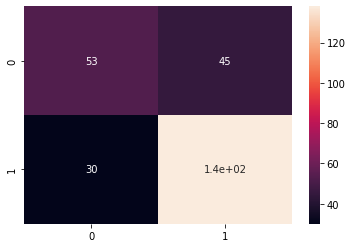

In [405]:
print(classification_report(test_Y, validation_prediction_MBatchL1))
conf_Matrix_MBGDL1 = confusion_matrix(test_Y, validation_prediction_MBatchL1)
sns.heatmap(conf_Matrix_MBGDL1, annot=True)
print("Accuracy : ", (conf_Matrix_MBGDL1[0,0] + conf_Matrix_MBGDL1[1,1])/(np.sum(conf_Matrix_MBGDL1)))

-----------------***********---------------------<br>
Comparing L1 and L2 on Mini Batch Gradient Descent<br>
-----------------***********---------------------<br>

<function matplotlib.pyplot.show>

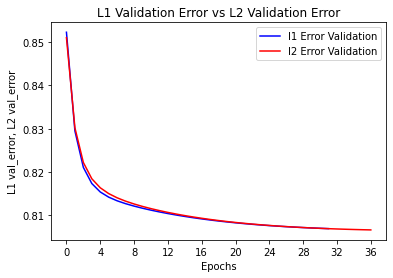

In [410]:
plt.plot(range(len(MiniBatch_ModelL1.ErrorValidation)), MiniBatch_ModelL1.ErrorValidation, c= 'blue', label = 'l1 Error Validation')
plt.plot(range(len(MiniBatch_ModelL2.ErrorValidation)), MiniBatch_ModelL2.ErrorValidation, c= 'red', label = 'l2 Error Validation')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs')
plt.ylabel('L1 val_error, L2 val_error')
plt.title("L1 Validation Error vs L2 Validation Error")
plt.legend()
plt.show

In Mini Batch, again there isn't any difference in the perfomance of l1 and l2 regualzation on our prediction. Tho the validation error on l1 slighty lower then l2.

#Review on All Three Methods

In Batch we had to do alot of epochs and at the end accuracy isn't the best when compared to other models.<br>

In Stochastic instead of finding derivate on all instance at once we calculate derivate on one instance and update our weights based on that. This approach saved us from doing so many epochs and got us the best possible result in less then 10 epochs.<br>

In Mini-Batch, we combined the approach of both batch and stochastic, which resulted in us having to do less epochs as well as improved accuracy.

Overall Stochastic Gradient Descent preformed the best. The highest accuracy with good f1 score is achieved using Stochastic GD.